In [30]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

## Connect to the Postgres DB using SQL Alchemy toolkit

In [31]:
from config import username, password, hostname_or_ip, port, DB
from sqlalchemy import create_engine
db_uri = f'postgresql://{username}:{password}@{hostname_or_ip}:{port}/{DB}'
engine = create_engine(db_uri, echo=True) #echo = True to log every query our SQL database executes to the terminal

In [32]:
connection = engine.connect()

2020-07-14 00:27:45,181 INFO sqlalchemy.engine.base.Engine select version()
2020-07-14 00:27:45,181 INFO sqlalchemy.engine.base.Engine {}
2020-07-14 00:27:45,183 INFO sqlalchemy.engine.base.Engine select current_schema()
2020-07-14 00:27:45,185 INFO sqlalchemy.engine.base.Engine {}
2020-07-14 00:27:45,192 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2020-07-14 00:27:45,194 INFO sqlalchemy.engine.base.Engine {}
2020-07-14 00:27:45,202 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2020-07-14 00:27:45,204 INFO sqlalchemy.engine.base.Engine {}
2020-07-14 00:27:45,210 INFO sqlalchemy.engine.base.Engine show standard_conforming_strings
2020-07-14 00:27:45,212 INFO sqlalchemy.engine.base.Engine {}


## Create a histogram to visualize the most common salary ranges for employees.

### Direct SQL query result to pandas DF

In [33]:
import pandas as pd

query = "SELECT emp.emp_no, sal.salary \
FROM employees AS emp \
LEFT JOIN salaries AS sal \
ON emp.emp_no = sal.emp_no"

#Using this query instead of "query = "SELECT * FROM salaries"" as emp_no ideally should be queries based on this table"

Employee_Salary_DF = pd.read_sql(
            query,
            con=connection
)

2020-07-14 00:27:45,415 INFO sqlalchemy.engine.base.Engine select relname from pg_class c join pg_namespace n on n.oid=c.relnamespace where pg_catalog.pg_table_is_visible(c.oid) and relname=%(name)s
2020-07-14 00:27:45,416 INFO sqlalchemy.engine.base.Engine {'name': 'SELECT emp.emp_no, sal.salary FROM employees AS emp LEFT JOIN salaries AS sal ON emp.emp_no = sal.emp_no'}
2020-07-14 00:27:45,420 INFO sqlalchemy.engine.base.Engine SELECT emp.emp_no, sal.salary FROM employees AS emp LEFT JOIN salaries AS sal ON emp.emp_no = sal.emp_no
2020-07-14 00:27:45,421 INFO sqlalchemy.engine.base.Engine {}


In [34]:
import pandas as pd

query = "SELECT * FROM salaries"

Employee_Salary_DF = pd.read_sql(
            query,
            con=connection
)

2020-07-14 00:27:46,447 INFO sqlalchemy.engine.base.Engine select relname from pg_class c join pg_namespace n on n.oid=c.relnamespace where pg_catalog.pg_table_is_visible(c.oid) and relname=%(name)s
2020-07-14 00:27:46,448 INFO sqlalchemy.engine.base.Engine {'name': 'SELECT * FROM salaries'}
2020-07-14 00:27:46,451 INFO sqlalchemy.engine.base.Engine SELECT * FROM salaries
2020-07-14 00:27:46,453 INFO sqlalchemy.engine.base.Engine {}


### Create histograms
- **Salary range is 40000 to 129492**
- **Mean salary is 52970.7**

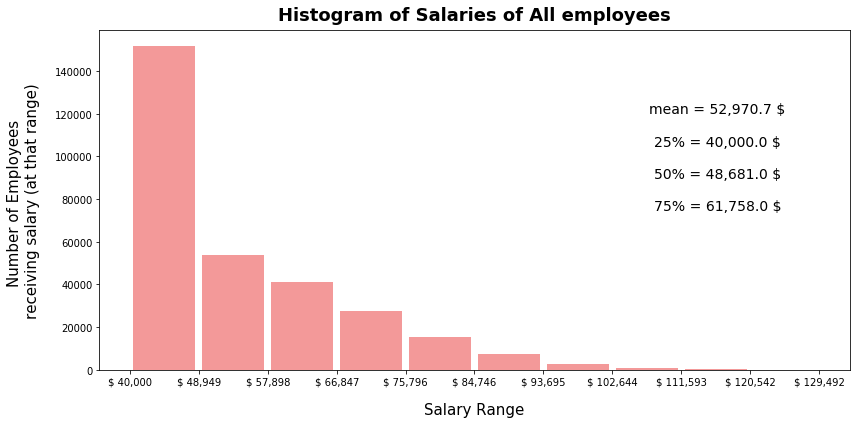

In [41]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12,6))
n, bins, patches = ax.hist(Employee_Salary_DF['salary'], color='lightcoral', alpha=0.8,bins=10, rwidth=0.9, zorder=1)
_=ax.set_title("Histogram of Salaries of All employees", fontsize=18, weight='bold', y=1.01)
_=ax.set_xlabel('Salary Range',fontsize = 15, labelpad=15)
_=ax.set_ylabel('Number of Employees \nreceiving salary (at that range)',fontsize = 15, labelpad=15)


#Annotation
#Mean, 25%, 50%(Median), 75% quartiles
label = '\n\n'.join(Employee_Salary_DF['salary'].describe().iloc[[1,4,5,6]].reset_index().apply(lambda x: "{} = {:,.1f} $".format(x['index'], x['salary']), axis=1).to_list())
(x,y) = (115000, 70000)
_=ax.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text ('offset pixels'  is the other option)
                 xytext=(10,10), # distance from text to points (x,y)
                 ha='center', # horizontal alignment can be left, right or center
                 fontsize=14,
                 color='k') 
_=plt.xticks(bins)
_=ax.set_xticklabels(["$ {:,}".format(int(val)) for val in bins], rotation=0)
_ = plt.tight_layout()
_= plt.savefig('../Images/histogram.png', bbox_inches = "tight" )


## Create a bar chart of average salary by title.

### Direct SQL query result to pandas DF

In [36]:
query = "SELECT titles.title, AVG(sal.salary) AS Average_Salary \
FROM employees AS emp \
LEFT JOIN salaries AS sal ON emp.emp_no = sal.emp_no \
LEFT JOIN titles ON emp.emp_title_id = titles.title_id \
GROUP BY titles.title \
ORDER BY Average_Salary DESC"

Employee_title_Agg_Salary_DF = pd.read_sql(
            query,
            con=connection
)

2020-07-14 00:27:47,654 INFO sqlalchemy.engine.base.Engine select relname from pg_class c join pg_namespace n on n.oid=c.relnamespace where pg_catalog.pg_table_is_visible(c.oid) and relname=%(name)s
2020-07-14 00:27:47,666 INFO sqlalchemy.engine.base.Engine {'name': 'SELECT titles.title, AVG(sal.salary) AS Average_Salary FROM employees AS emp LEFT JOIN salaries AS sal ON emp.emp_no = sal.emp_no LEFT JOIN titles ON emp.emp_title_id = titles.title_id GROUP BY titles.title ORDER BY Average_Salary DESC'}
2020-07-14 00:27:47,671 INFO sqlalchemy.engine.base.Engine SELECT titles.title, AVG(sal.salary) AS Average_Salary FROM employees AS emp LEFT JOIN salaries AS sal ON emp.emp_no = sal.emp_no LEFT JOIN titles ON emp.emp_title_id = titles.title_id GROUP BY titles.title ORDER BY Average_Salary DESC
2020-07-14 00:27:47,677 INFO sqlalchemy.engine.base.Engine {}


In [37]:
Employee_title_Agg_Salary_DF

,title,average_salary
0,Senior Staff,58550.172704
1,Staff,58465.382850
2,Manager,51531.041667
3,Technique Leader,48582.896092
4,Assistant Engineer,48564.434447
5,Engineer,48535.336511
6,Senior Engineer,48506.799871


### Create bar chart
- **All the technical positions have less average salary compared to managerial positions**
- **Senior Engineer position has less average salary than Engineer and Assistant Engineer. This is a proof that this data is fake**

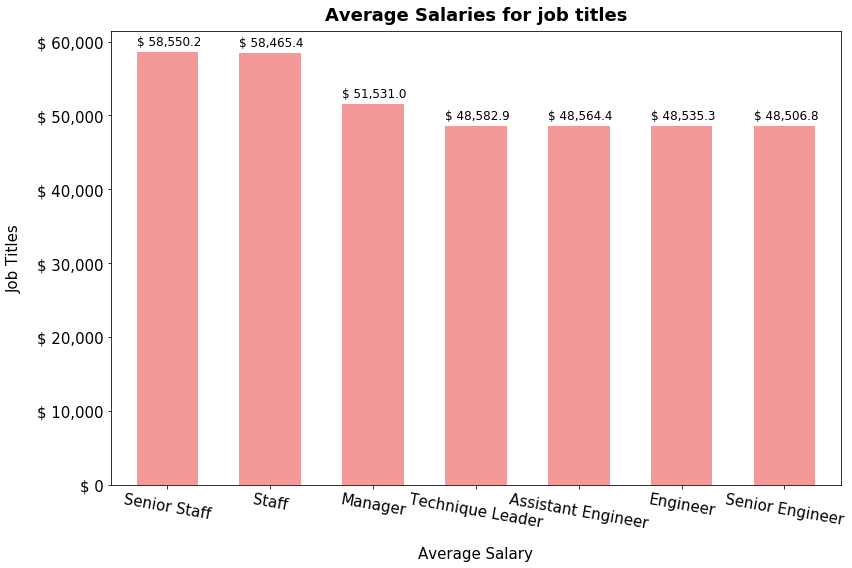

In [38]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12,8))
#_=Employee_Salary_DF.hist(column='salary', ax=ax, color='lightcoral', alpha=0.8, grid=False, bins=16, rwidth=0.9, zorder=1)
_=Employee_title_Agg_Salary_DF.plot.bar(x='title', y='average_salary',color='lightcoral',alpha=0.8, ax=ax, legend=None, width=0.6, rot=-10, fontsize=15)
_=ax.set_title("Average Salaries for job titles", fontsize=18, weight='bold', y=1.01)
_=ax.set_xlabel('Average Salary',fontsize = 15, labelpad=15)
_=ax.set_ylabel('Job Titles',fontsize = 15, labelpad=15)


#Annotate
_=ax.set_yticklabels(["$ {:,}".format(int(val)) for val in ax.get_yticks()])
for p in ax.patches:
    _=ax.annotate("$ {:,.1f}".format(p.get_height()), (p.get_x(), p.get_height()+1000), fontsize=12)
    
_ = plt.tight_layout()
_= plt.savefig('../Images/Avg_salary_per_title.png', bbox_inches = "tight" )



# Epilogue
## What is with "499942" emp id ?

In [39]:
query = "SELECT emp.birth_date, emp.first_name, emp.last_name, emp.sex, emp.hire_date, \
sal.salary,  titles.title, dept.dept_name \
FROM employees AS emp \
LEFT JOIN salaries AS sal ON emp.emp_no = sal.emp_no \
LEFT JOIN titles ON emp.emp_title_id = titles.title_id \
LEFT JOIN dept_emp AS depEmp ON emp.emp_no = depEmp.emp_no \
LEFT JOIN departments AS dept ON depEmp.dept_no = dept.dept_no \
WHERE emp.emp_no = 499942"

MyData_DF = pd.read_sql(
            query,
            con=connection
)

2020-07-14 00:27:48,898 INFO sqlalchemy.engine.base.Engine select relname from pg_class c join pg_namespace n on n.oid=c.relnamespace where pg_catalog.pg_table_is_visible(c.oid) and relname=%(name)s
2020-07-14 00:27:48,910 INFO sqlalchemy.engine.base.Engine {'name': 'SELECT emp.birth_date, emp.first_name, emp.last_name, emp.sex, emp.hire_date, sal.salary,  titles.title, dept.dept_name FROM employees AS emp LEFT JO ... (99 characters truncated) ... d LEFT JOIN dept_emp AS depEmp ON emp.emp_no = depEmp.emp_no LEFT JOIN departments AS dept ON depEmp.dept_no = dept.dept_no WHERE emp.emp_no = 499942'}
2020-07-14 00:27:48,913 INFO sqlalchemy.engine.base.Engine SELECT emp.birth_date, emp.first_name, emp.last_name, emp.sex, emp.hire_date, sal.salary,  titles.title, dept.dept_name FROM employees AS emp LEFT JOIN salaries AS sal ON emp.emp_no = sal.emp_no LEFT JOIN titles ON emp.emp_title_id = titles.title_id LEFT JOIN dept_emp AS depEmp ON emp.emp_no = depEmp.emp_no LEFT JOIN departments AS dep

In [40]:
MyData_DF

,birth_date,first_name,last_name,sex,hire_date,salary,title,dept_name
0,1963-01-10,April,Foolsday,F,1997-02-10,40000,Technique Leader,Development
